In [428]:
!pip install wget torchinfo

In [ ]:
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

print("dataset setup complete!")

--2025-02-27 18:49:11--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-02-27 18:49:12--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip   1%[                    ] 112.58M  16.1MB/s    eta 14m 3s 

In [429]:
!pip install peft

In [430]:
!pip install torchao
!pip install torchtune

In [431]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [432]:
from torchtune.modules.peft import LoRALinear

In [433]:
def convert_to_lora_model(model, rank=8, alpha=16, exclude=[]):
    for name, module in model.named_children():
        if name in exclude:
            continue
        if isinstance(module, nn.Linear):
            lora_linear = LoRALinear(
                in_dim=module.in_features,
                out_dim=module.out_features,
                rank=rank,
                alpha=alpha,
                use_bias=module.bias is not None
            )
            lora_linear.weight.data = module.weight.data #모델이 처음부터 다시 학습할 필요 없게 하기 위해
            if module.bias is not None:
                lora_linear.bias.data = module.bias.data
            lora_linear.to(module.weight.device)
            # 기존 linear layer를 loRA linear로 교체체
            setattr(model, name, lora_linear)
        # 재귀함수 (하위모듈도 확인)
        else:
            convert_to_lora_model(module, rank, alpha, exclude)

    return model

In [434]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [435]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [436]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [437]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [438]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [439]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [440]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [441]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [442]:
import torch.nn.functional as F

class LevitStage_TinyFusion(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, num_select, downsample=True):
        super(LevitStage_TinyFusion, self).__init__()
        assert num_select <= num_blocks
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])
        self.num_blocks = num_blocks
        self.num_select = num_select
        init_probs = torch.ones(num_blocks) / num_blocks
        self.gumbel_gate = nn.Parameter(torch.log(init_probs))


    def forward(self, x, tau=1):
        x = self.downsample(x)

        if self.training:
            gate_probs = F.gumbel_softmax(self.gumbel_gate, tau=tau, hard=False)
        else:
            gate_probs = F.gumbel_softmax(self.gumbel_gate, tau=tau, hard=True)

        for i in range(self.num_blocks):
            if gate_probs[i] > 0: # skip zero blocks
              x = x + gate_probs[i] * self.blocks[i](x)
        return x

In [443]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [444]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [445]:
class LevitDistilledTinyfusion(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilledTinyfusion, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage_TinyFusion(dim=256, out_dim=256, num_heads=4, num_blocks=4, num_select=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage_TinyFusion(dim=256, out_dim=384, num_heads=6, num_blocks=4, num_select=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x, tau):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x, tau)
        x = self.stage2(x, tau)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [446]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=4, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=4, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [447]:
model = LevitDistilledTinyfusion(num_classes=9)

In [448]:
#model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
num_epochs = 45
weight_decay = 1e-6

LevitDistilledTinyfusion(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): Levi

In [449]:
print(summary(model, input_size=(32, 3, 224, 224), tau = 10))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilledTinyfusion                                [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [450]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2, tau = 10))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilledTinyfusion                                [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [451]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilledTinyfusion(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): Levi

In [452]:
train_dir     = './train/NCT-CRC-HE-100K'

In [453]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [454]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [458]:
import json

with open("default_index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [459]:
train_data = Subset(dataset, load_train_idx)
val_data = Subset(dataset, load_val_idx)
test_data = Subset(dataset, load_test_idx)

In [460]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


In [461]:
gumbel_params = []
other_params = []
exclude = ["head", "head_dist"]

for name, module in model.named_children():
    if name in exclude:
        print(exclude)

for name, param in model.named_parameters():
    if "gumbel_gate" in name:
        gumbel_params.append(param)
        print(name)
    else:
        other_params.append(param)

#model = convert_to_lora_model(model, exclude=exclude)

['head', 'head_dist']
['head', 'head_dist']
stage1.gumbel_gate
stage2.gumbel_gate


In [462]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [463]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, requires_grad: {param.requires_grad}")

Parameter name: stem.conv1.linear.weight, requires_grad: True
Parameter name: stem.conv1.bn.weight, requires_grad: True
Parameter name: stem.conv1.bn.bias, requires_grad: True
Parameter name: stem.conv2.linear.weight, requires_grad: True
Parameter name: stem.conv2.bn.weight, requires_grad: True
Parameter name: stem.conv2.bn.bias, requires_grad: True
Parameter name: stem.conv3.linear.weight, requires_grad: True
Parameter name: stem.conv3.bn.weight, requires_grad: True
Parameter name: stem.conv3.bn.bias, requires_grad: True
Parameter name: stem.conv4.linear.weight, requires_grad: True
Parameter name: stem.conv4.bn.weight, requires_grad: True
Parameter name: stem.conv4.bn.bias, requires_grad: True
Parameter name: stage1.gumbel_gate, requires_grad: True
Parameter name: stage1.blocks.0.attn.attention_biases, requires_grad: True
Parameter name: stage1.blocks.0.attn.qkv.linear.weight, requires_grad: True
Parameter name: stage1.blocks.0.attn.qkv.bn.weight, requires_grad: True
Parameter name: s

In [464]:
def transfer_weights(pretrained_model: LevitDistilled, tinyfusion_model: LevitDistilledTinyfusion, num_blocks):

    pretrained_dict = pretrained_model.state_dict()
    tinyfusion_dict = tinyfusion_model.state_dict()

    new_state_dict = {}

    # 1️⃣ 공통된 가중치 복사 (stem, conv1x1, head, head_dist)
    for key in tinyfusion_dict.keys():
        if key in pretrained_dict and not key.startswith("stage"):
            new_state_dict[key] = pretrained_dict[key]

    stage = []
    for i in range(num_blocks):
        stage.append(f"stage{i}")
    # 2️⃣ stage1, stage2의 가중치 변환 적용
    for stage_name in stage:
        for i in range(num_blocks):  # num_blocks=4
            old_key = f"{stage_name}.blocks.{i}"  # 원래 모델의 key
            new_key = f"{stage_name}.blocks.{i}"  # TinyFusion 모델의 key

            if old_key in pretrained_dict and new_key in tinyfusion_dict:
                new_state_dict[new_key] = pretrained_dict[old_key]

    # 3️⃣ `gumble_gate`는 원래 모델에 없으므로, 초기화된 값 유지 (로드 안함)
    print("✅ 가중치 변환 완료! TinyFusion 모델에 적용합니다.")

    # 4️⃣ 변환된 가중치를 TinyFusion 모델에 로드 (strict=False)
    tinyfusion_model.load_state_dict(new_state_dict, strict=False)

In [465]:
pretrained_model = LevitDistilled(num_classes=9)
pretrained_model.stage1.blocks[0].attn.compute_attention_bias(14)
pretrained_model.stage1.blocks[1].attn.compute_attention_bias(14)
pretrained_model.stage1.blocks[2].attn.compute_attention_bias(14)
pretrained_model.stage1.blocks[3].attn.compute_attention_bias(14)
pretrained_model.stage2.blocks[0].attn.compute_attention_bias(7)
pretrained_model.stage2.blocks[1].attn.compute_attention_bias(7)
pretrained_model.stage2.blocks[2].attn.compute_attention_bias(7)
pretrained_model.stage2.blocks[3].attn.compute_attention_bias(7)
model.stage1.blocks[0].attn.compute_attention_bias(14)
model.stage1.blocks[1].attn.compute_attention_bias(14)
model.stage1.blocks[2].attn.compute_attention_bias(14)
model.stage1.blocks[3].attn.compute_attention_bias(14)
model.stage2.blocks[0].attn.compute_attention_bias(7)
model.stage2.blocks[1].attn.compute_attention_bias(7)
model.stage2.blocks[2].attn.compute_attention_bias(7)
model.stage2.blocks[3].attn.compute_attention_bias(7)
pretrained_model.load_state_dict(torch.load("BaseLine_HoViT_44.pth"))

<ipython-input-465-50b800dbf540>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load("BaseLine_HoViT_44.pth"))


<All keys matched successfully>

In [466]:
transfer_weights(pretrained_model, model, num_blocks=4)

✅ 가중치 변환 완료! TinyFusion 모델에 적용합니다.


In [467]:
model = convert_to_lora_model(model, exclude=exclude)

In [468]:
for name, param in model.named_parameters():
    if "lora_a" in name or "lora_b" in name:
        param.requires_grad = True
        print(f"✅ LoRA Trainable: {name}")
    if "gumbel_gate" in name:
        param.requires_grad = True
        print(f"✅ TinyFusion Trainable: {name}")
    elif "head" in name or "head_dist" in name:
        param.requires_grad = True
        print(f"✅ Head Trainable: {name}")
    elif "conv1x1" in name:
        param.requires_grad = True
        print(f"✅ Conv1x1 Trainable: {name}")
    elif "attention_biases" in name:
        param.requires_grad = True
        print(f"✅ Attention Biases Trainable: {name}")
    else:
        param.requires_grad = False

✅ TinyFusion Trainable: stage1.gumbel_gate
✅ Attention Biases Trainable: stage1.blocks.0.attn.attention_biases
✅ LoRA Trainable: stage1.blocks.0.attn.qkv.linear.lora_a.weight
✅ LoRA Trainable: stage1.blocks.0.attn.qkv.linear.lora_b.weight
✅ LoRA Trainable: stage1.blocks.0.attn.proj.1.linear.lora_a.weight
✅ LoRA Trainable: stage1.blocks.0.attn.proj.1.linear.lora_b.weight
✅ LoRA Trainable: stage1.blocks.0.mlp.ln1.linear.lora_a.weight
✅ LoRA Trainable: stage1.blocks.0.mlp.ln1.linear.lora_b.weight
✅ LoRA Trainable: stage1.blocks.0.mlp.ln2.linear.lora_a.weight
✅ LoRA Trainable: stage1.blocks.0.mlp.ln2.linear.lora_b.weight
✅ Attention Biases Trainable: stage1.blocks.1.attn.attention_biases
✅ LoRA Trainable: stage1.blocks.1.attn.qkv.linear.lora_a.weight
✅ LoRA Trainable: stage1.blocks.1.attn.qkv.linear.lora_b.weight
✅ LoRA Trainable: stage1.blocks.1.attn.proj.1.linear.lora_a.weight
✅ LoRA Trainable: stage1.blocks.1.attn.proj.1.linear.lora_b.weight
✅ LoRA Trainable: stage1.blocks.1.mlp.ln1.lin

In [469]:
# gumbel_gate 파라미터가 포함되어 있는지 확인
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, requires_grad: {param.requires_grad}")

Parameter name: stem.conv1.linear.weight, requires_grad: False
Parameter name: stem.conv1.bn.weight, requires_grad: False
Parameter name: stem.conv1.bn.bias, requires_grad: False
Parameter name: stem.conv2.linear.weight, requires_grad: False
Parameter name: stem.conv2.bn.weight, requires_grad: False
Parameter name: stem.conv2.bn.bias, requires_grad: False
Parameter name: stem.conv3.linear.weight, requires_grad: False
Parameter name: stem.conv3.bn.weight, requires_grad: False
Parameter name: stem.conv3.bn.bias, requires_grad: False
Parameter name: stem.conv4.linear.weight, requires_grad: False
Parameter name: stem.conv4.bn.weight, requires_grad: False
Parameter name: stem.conv4.bn.bias, requires_grad: False
Parameter name: stage1.gumbel_gate, requires_grad: True
Parameter name: stage1.blocks.0.attn.attention_biases, requires_grad: True
Parameter name: stage1.blocks.0.attn.qkv.linear.weight, requires_grad: False
Parameter name: stage1.blocks.0.attn.qkv.linear.lora_a.weight, requires_grad

In [470]:
gumbel_params = []
other_params = []
exclude = ["head", "head_dist"]

for name, module in model.named_children():
    if name in exclude:
        print(exclude)

for name, param in model.named_parameters():
    if "gumbel_gate" in name:
        gumbel_params.append(param)
        print(name)
    else:
        other_params.append(param)

['head', 'head_dist']
['head', 'head_dist']
stage1.gumbel_gate
stage2.gumbel_gate


In [471]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params' : gumbel_params, 'lr': learning_rate * 10},
    {'params' : other_params, 'lr': learning_rate}
])

In [472]:
def train(model, train_loader, criterion, optimizer, device, epoch, total_epcohs=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    tau_max = 1
    tau_min = 0.1
    total_steps = total_epcohs * len(train_loader)
    train_steps = epoch * len(train_loader)

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        tau = tau_max - (tau_max - tau_min) * min(1.0, (train_steps + i) / total_steps)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, tau)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    print(f"Tau: {tau:.4f}")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

    print("Each stage of block probabilities:")
    for name, module in model.named_modules():
        if isinstance(module, LevitStage_TinyFusion):
            gate_probs = torch.softmax(module.gumbel_gate, dim=0) # 각 block의 확률
            topk_indx = torch.topk(gate_probs, module.num_select).indices.tolist() # 상위 k개의 index
            print(f"{name}")
            for i, prob in enumerate(gate_probs):
                mask = " " if i in topk_indx else "*" # mask
                print(f"Block {i}: {prob:.4f} {mask}")

In [473]:
def evaluate(model, data_loader, criterion, device, phase="Validation", epoch=0, total_epcohs=100):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    tau_max = 1
    tau_min = 0.1
    total_steps = total_epcohs * len(data_loader)
    train_steps = epoch * len(data_loader)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"{phase}")):
            inputs, labels = inputs.to(device), labels.to(device)
            if phase == "Validation":
                tau = tau_max - (tau_max - tau_min) * min(1.0, (train_steps + i) / total_steps)
            elif phase == "Test":
                tau = 1e-5
            outputs = model(inputs, tau)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Tau: {tau:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [474]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs, tau=0.1)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [475]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, requires_grad: {param.requires_grad}")

Parameter name: stem.conv1.linear.weight, requires_grad: False
Parameter name: stem.conv1.bn.weight, requires_grad: False
Parameter name: stem.conv1.bn.bias, requires_grad: False
Parameter name: stem.conv2.linear.weight, requires_grad: False
Parameter name: stem.conv2.bn.weight, requires_grad: False
Parameter name: stem.conv2.bn.bias, requires_grad: False
Parameter name: stem.conv3.linear.weight, requires_grad: False
Parameter name: stem.conv3.bn.weight, requires_grad: False
Parameter name: stem.conv3.bn.bias, requires_grad: False
Parameter name: stem.conv4.linear.weight, requires_grad: False
Parameter name: stem.conv4.bn.weight, requires_grad: False
Parameter name: stem.conv4.bn.bias, requires_grad: False
Parameter name: stage1.gumbel_gate, requires_grad: True
Parameter name: stage1.blocks.0.attn.attention_biases, requires_grad: True
Parameter name: stage1.blocks.0.attn.qkv.linear.weight, requires_grad: False
Parameter name: stage1.blocks.0.attn.qkv.linear.lora_a.weight, requires_grad

In [476]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch)
    evaluate(model, val_loader, criterion, device, phase="Validation", epoch=epoch)
    if((epoch+1) % 10 == 0 and epoch > 30):
        save_path = f"HoViT_44_tinyfusion_base_r8a16_{epoch}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Model weights saved to {save_path}")
        print(f"{epoch+1} model test result:")
        evaluate(model, test_loader, criterion, device, phase="Test")


Epoch 1/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.24it/s]


Train Loss: 0.3165, Train Accuracy: 90.60%
Tau: 0.9910
Each stage of block probabilities:
stage1
Block 0: 0.7945  
Block 1: 0.1068  
Block 2: 0.0585 *
Block 3: 0.0402 *
stage2
Block 0: 0.2018 *
Block 1: 0.1850 *
Block 2: 0.3359  
Block 3: 0.2773  


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


Validation Loss: 0.2649, Validation Accuracy: 91.19%
Balanced Accuracy: 0.9112
Tau: 0.9910

Epoch 2/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.30it/s]


Train Loss: 0.1288, Train Accuracy: 95.69%
Tau: 0.9820
Each stage of block probabilities:
stage1
Block 0: 0.9553  
Block 1: 0.0249  
Block 2: 0.0106 *
Block 3: 0.0092 *
stage2
Block 0: 0.2102 *
Block 1: 0.1858 *
Block 2: 0.3472  
Block 3: 0.2567  


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


Validation Loss: 0.1227, Validation Accuracy: 96.00%
Balanced Accuracy: 0.9593
Tau: 0.9820

Epoch 3/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.27it/s]


Train Loss: 0.0896, Train Accuracy: 97.04%
Tau: 0.9730
Each stage of block probabilities:
stage1
Block 0: 0.9868  
Block 1: 0.0065  
Block 2: 0.0041 *
Block 3: 0.0027 *
stage2
Block 0: 0.1985 *
Block 1: 0.1774 *
Block 2: 0.3472  
Block 3: 0.2769  


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]


Validation Loss: 0.0878, Validation Accuracy: 97.11%
Balanced Accuracy: 0.9699
Tau: 0.9730

Epoch 4/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.27it/s]


Train Loss: 0.0691, Train Accuracy: 97.72%
Tau: 0.9640
Each stage of block probabilities:
stage1
Block 0: 0.9960  
Block 1: 0.0021  
Block 2: 0.0012 *
Block 3: 0.0007 *
stage2
Block 0: 0.2142 *
Block 1: 0.1516 *
Block 2: 0.3972  
Block 3: 0.2370  


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]


Validation Loss: 0.0714, Validation Accuracy: 97.72%
Balanced Accuracy: 0.9765
Tau: 0.9640

Epoch 5/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.25it/s]


Train Loss: 0.0555, Train Accuracy: 98.16%
Tau: 0.9550
Each stage of block probabilities:
stage1
Block 0: 0.9978  
Block 1: 0.0010  
Block 2: 0.0007 *
Block 3: 0.0005 *
stage2
Block 0: 0.2263  
Block 1: 0.1148 *
Block 2: 0.4745  
Block 3: 0.1845 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]


Validation Loss: 0.0783, Validation Accuracy: 97.61%
Balanced Accuracy: 0.9757
Tau: 0.9550

Epoch 6/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.29it/s]


Train Loss: 0.0444, Train Accuracy: 98.55%
Tau: 0.9460
Each stage of block probabilities:
stage1
Block 0: 0.9986  
Block 1: 0.0007  
Block 2: 0.0004 *
Block 3: 0.0003 *
stage2
Block 0: 0.2270  
Block 1: 0.1165 *
Block 2: 0.4606  
Block 3: 0.1959 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]


Validation Loss: 0.0749, Validation Accuracy: 97.83%
Balanced Accuracy: 0.9779
Tau: 0.9460

Epoch 7/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0361, Train Accuracy: 98.86%
Tau: 0.9370
Each stage of block probabilities:
stage1
Block 0: 0.9990  
Block 1: 0.0005  
Block 2: 0.0003 *
Block 3: 0.0002 *
stage2
Block 0: 0.2107  
Block 1: 0.0909 *
Block 2: 0.5294  
Block 3: 0.1690 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]


Validation Loss: 0.0902, Validation Accuracy: 97.75%
Balanced Accuracy: 0.9773
Tau: 0.9370

Epoch 8/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0280, Train Accuracy: 99.12%
Tau: 0.9280
Each stage of block probabilities:
stage1
Block 0: 0.9995  
Block 1: 0.0002  
Block 2: 0.0002 *
Block 3: 0.0001 *
stage2
Block 0: 0.1989  
Block 1: 0.0736 *
Block 2: 0.6063  
Block 3: 0.1212 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]


Validation Loss: 0.0594, Validation Accuracy: 98.06%
Balanced Accuracy: 0.9803
Tau: 0.9280

Epoch 9/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.25it/s]


Train Loss: 0.0249, Train Accuracy: 99.21%
Tau: 0.9190
Each stage of block probabilities:
stage1
Block 0: 0.9997  
Block 1: 0.0001 *
Block 2: 0.0001  
Block 3: 0.0001 *
stage2
Block 0: 0.2073  
Block 1: 0.0690 *
Block 2: 0.6244  
Block 3: 0.0993 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.00it/s]


Validation Loss: 0.0782, Validation Accuracy: 97.75%
Balanced Accuracy: 0.9774
Tau: 0.9190

Epoch 10/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.27it/s]


Train Loss: 0.0195, Train Accuracy: 99.42%
Tau: 0.9100
Each stage of block probabilities:
stage1
Block 0: 0.9997  
Block 1: 0.0001 *
Block 2: 0.0001  
Block 3: 0.0001 *
stage2
Block 0: 0.2004  
Block 1: 0.0663 *
Block 2: 0.6575  
Block 3: 0.0759 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]


Validation Loss: 0.0696, Validation Accuracy: 98.09%
Balanced Accuracy: 0.9807
Tau: 0.9100

Epoch 11/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.28it/s]


Train Loss: 0.0162, Train Accuracy: 99.49%
Tau: 0.9010
Each stage of block probabilities:
stage1
Block 0: 0.9998  
Block 1: 0.0001 *
Block 2: 0.0001  
Block 3: 0.0000 *
stage2
Block 0: 0.1872  
Block 1: 0.0478 *
Block 2: 0.6906  
Block 3: 0.0744 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]


Validation Loss: 0.0689, Validation Accuracy: 97.99%
Balanced Accuracy: 0.9797
Tau: 0.9010

Epoch 12/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0136, Train Accuracy: 99.62%
Tau: 0.8920
Each stage of block probabilities:
stage1
Block 0: 0.9998  
Block 1: 0.0001  
Block 2: 0.0001 *
Block 3: 0.0000 *
stage2
Block 0: 0.1433  
Block 1: 0.0405 *
Block 2: 0.7682  
Block 3: 0.0481 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]


Validation Loss: 0.0582, Validation Accuracy: 98.26%
Balanced Accuracy: 0.9821
Tau: 0.8920

Epoch 13/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.25it/s]


Train Loss: 0.0121, Train Accuracy: 99.63%
Tau: 0.8830
Each stage of block probabilities:
stage1
Block 0: 0.9998  
Block 1: 0.0001 *
Block 2: 0.0001  
Block 3: 0.0000 *
stage2
Block 0: 0.1858  
Block 1: 0.0405 *
Block 2: 0.7284  
Block 3: 0.0452 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]


Validation Loss: 0.0593, Validation Accuracy: 98.12%
Balanced Accuracy: 0.9814
Tau: 0.8830

Epoch 14/45


Training: 100%|██████████| 2188/2188 [03:15<00:00, 11.20it/s]


Train Loss: 0.0113, Train Accuracy: 99.63%
Tau: 0.8740
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0001  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1704  
Block 1: 0.0282 *
Block 2: 0.7757  
Block 3: 0.0257 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]


Validation Loss: 0.0664, Validation Accuracy: 98.41%
Balanced Accuracy: 0.9839
Tau: 0.8740

Epoch 15/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0086, Train Accuracy: 99.75%
Tau: 0.8650
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0001  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1475  
Block 1: 0.0257 *
Block 2: 0.8011  
Block 3: 0.0256 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Validation Loss: 0.0633, Validation Accuracy: 98.36%
Balanced Accuracy: 0.9835
Tau: 0.8650

Epoch 16/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.28it/s]


Train Loss: 0.0090, Train Accuracy: 99.72%
Tau: 0.8560
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0001  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.2502  
Block 1: 0.0307 *
Block 2: 0.6963  
Block 3: 0.0228 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]


Validation Loss: 0.0609, Validation Accuracy: 98.35%
Balanced Accuracy: 0.9834
Tau: 0.8560

Epoch 17/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0082, Train Accuracy: 99.74%
Tau: 0.8470
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0001  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1951  
Block 1: 0.0189 *
Block 2: 0.7740  
Block 3: 0.0120 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]


Validation Loss: 0.0567, Validation Accuracy: 98.49%
Balanced Accuracy: 0.9852
Tau: 0.8470

Epoch 18/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.29it/s]


Train Loss: 0.0089, Train Accuracy: 99.70%
Tau: 0.8380
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0001  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1740  
Block 1: 0.0177 *
Block 2: 0.7970  
Block 3: 0.0113 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]


Validation Loss: 0.0548, Validation Accuracy: 98.60%
Balanced Accuracy: 0.9864
Tau: 0.8380

Epoch 19/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.30it/s]


Train Loss: 0.0071, Train Accuracy: 99.77%
Tau: 0.8290
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1151  
Block 1: 0.0152 *
Block 2: 0.8605  
Block 3: 0.0091 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]


Validation Loss: 0.0716, Validation Accuracy: 98.12%
Balanced Accuracy: 0.9812
Tau: 0.8290

Epoch 20/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.30it/s]


Train Loss: 0.0063, Train Accuracy: 99.81%
Tau: 0.8200
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1698  
Block 1: 0.0225 *
Block 2: 0.7983  
Block 3: 0.0094 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]


Validation Loss: 0.0557, Validation Accuracy: 98.62%
Balanced Accuracy: 0.9864
Tau: 0.8200

Epoch 21/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.29it/s]


Train Loss: 0.0066, Train Accuracy: 99.79%
Tau: 0.8110
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1241  
Block 1: 0.0132 *
Block 2: 0.8563  
Block 3: 0.0063 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]


Validation Loss: 0.0543, Validation Accuracy: 98.53%
Balanced Accuracy: 0.9851
Tau: 0.8110

Epoch 22/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.33it/s]


Train Loss: 0.0052, Train Accuracy: 99.84%
Tau: 0.8020
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1050  
Block 1: 0.0104 *
Block 2: 0.8789  
Block 3: 0.0057 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]


Validation Loss: 0.0584, Validation Accuracy: 98.49%
Balanced Accuracy: 0.9849
Tau: 0.8020

Epoch 23/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0063, Train Accuracy: 99.80%
Tau: 0.7930
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1324  
Block 1: 0.0120 *
Block 2: 0.8512  
Block 3: 0.0044 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]


Validation Loss: 0.0570, Validation Accuracy: 98.58%
Balanced Accuracy: 0.9861
Tau: 0.7930

Epoch 24/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.30it/s]


Train Loss: 0.0049, Train Accuracy: 99.84%
Tau: 0.7840
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1096  
Block 1: 0.0113 *
Block 2: 0.8752  
Block 3: 0.0038 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]


Validation Loss: 0.0555, Validation Accuracy: 98.67%
Balanced Accuracy: 0.9866
Tau: 0.7840

Epoch 25/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0056, Train Accuracy: 99.83%
Tau: 0.7750
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0001  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1536  
Block 1: 0.0130 *
Block 2: 0.8295  
Block 3: 0.0039 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Validation Loss: 0.0694, Validation Accuracy: 98.31%
Balanced Accuracy: 0.9836
Tau: 0.7750

Epoch 26/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.25it/s]


Train Loss: 0.0041, Train Accuracy: 99.88%
Tau: 0.7660
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0964  
Block 1: 0.0077 *
Block 2: 0.8937  
Block 3: 0.0023 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]


Validation Loss: 0.0557, Validation Accuracy: 98.75%
Balanced Accuracy: 0.9876
Tau: 0.7660

Epoch 27/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0049, Train Accuracy: 99.84%
Tau: 0.7570
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1123  
Block 1: 0.0069 *
Block 2: 0.8785  
Block 3: 0.0022 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]


Validation Loss: 0.0610, Validation Accuracy: 98.49%
Balanced Accuracy: 0.9851
Tau: 0.7570

Epoch 28/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.29it/s]


Train Loss: 0.0053, Train Accuracy: 99.85%
Tau: 0.7480
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1343  
Block 1: 0.0088 *
Block 2: 0.8542  
Block 3: 0.0027 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]


Validation Loss: 0.0563, Validation Accuracy: 98.62%
Balanced Accuracy: 0.9857
Tau: 0.7480

Epoch 29/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.29it/s]


Train Loss: 0.0049, Train Accuracy: 99.84%
Tau: 0.7390
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1216  
Block 1: 0.0049 *
Block 2: 0.8716  
Block 3: 0.0019 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]


Validation Loss: 0.0608, Validation Accuracy: 98.72%
Balanced Accuracy: 0.9868
Tau: 0.7390

Epoch 30/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.31it/s]


Train Loss: 0.0032, Train Accuracy: 99.91%
Tau: 0.7300
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0878  
Block 1: 0.0045 *
Block 2: 0.9064  
Block 3: 0.0013 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s]


Validation Loss: 0.0606, Validation Accuracy: 98.58%
Balanced Accuracy: 0.9856
Tau: 0.7300

Epoch 31/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.27it/s]


Train Loss: 0.0046, Train Accuracy: 99.85%
Tau: 0.7210
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0702  
Block 1: 0.0039 *
Block 2: 0.9247  
Block 3: 0.0012 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


Validation Loss: 0.0604, Validation Accuracy: 98.70%
Balanced Accuracy: 0.9871
Tau: 0.7210

Epoch 32/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.30it/s]


Train Loss: 0.0038, Train Accuracy: 99.89%
Tau: 0.7120
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0589  
Block 1: 0.0033 *
Block 2: 0.9367  
Block 3: 0.0011 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]


Validation Loss: 0.0569, Validation Accuracy: 98.71%
Balanced Accuracy: 0.9869
Tau: 0.7120

Epoch 33/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.27it/s]


Train Loss: 0.0042, Train Accuracy: 99.88%
Tau: 0.7030
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.1081  
Block 1: 0.0043 *
Block 2: 0.8861  
Block 3: 0.0014 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]


Validation Loss: 0.0550, Validation Accuracy: 98.81%
Balanced Accuracy: 0.9877
Tau: 0.7030

Epoch 34/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.30it/s]


Train Loss: 0.0044, Train Accuracy: 99.87%
Tau: 0.6940
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0683  
Block 1: 0.0038 *
Block 2: 0.9264  
Block 3: 0.0014 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]


Validation Loss: 0.0548, Validation Accuracy: 98.85%
Balanced Accuracy: 0.9883
Tau: 0.6940

Epoch 35/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.30it/s]


Train Loss: 0.0028, Train Accuracy: 99.92%
Tau: 0.6850
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0487  
Block 1: 0.0025 *
Block 2: 0.9477  
Block 3: 0.0011 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]


Validation Loss: 0.0594, Validation Accuracy: 98.80%
Balanced Accuracy: 0.9880
Tau: 0.6850

Epoch 36/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.30it/s]


Train Loss: 0.0041, Train Accuracy: 99.87%
Tau: 0.6760
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0791  
Block 1: 0.0033 *
Block 2: 0.9165  
Block 3: 0.0010 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]


Validation Loss: 0.0575, Validation Accuracy: 98.83%
Balanced Accuracy: 0.9883
Tau: 0.6760

Epoch 37/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.22it/s]


Train Loss: 0.0027, Train Accuracy: 99.91%
Tau: 0.6670
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0545  
Block 1: 0.0021 *
Block 2: 0.9425  
Block 3: 0.0009 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]


Validation Loss: 0.0668, Validation Accuracy: 98.76%
Balanced Accuracy: 0.9876
Tau: 0.6670

Epoch 38/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.27it/s]


Train Loss: 0.0034, Train Accuracy: 99.90%
Tau: 0.6580
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0333  
Block 1: 0.0015 *
Block 2: 0.9645  
Block 3: 0.0007 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]


Validation Loss: 0.0695, Validation Accuracy: 98.54%
Balanced Accuracy: 0.9862
Tau: 0.6580

Epoch 39/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.27it/s]


Train Loss: 0.0044, Train Accuracy: 99.86%
Tau: 0.6490
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0150  
Block 1: 0.0009 *
Block 2: 0.9837  
Block 3: 0.0004 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]


Validation Loss: 0.0624, Validation Accuracy: 98.80%
Balanced Accuracy: 0.9880
Tau: 0.6490

Epoch 40/45


Training: 100%|██████████| 2188/2188 [03:13<00:00, 11.29it/s]


Train Loss: 0.0032, Train Accuracy: 99.90%
Tau: 0.6400
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0145  
Block 1: 0.0008 *
Block 2: 0.9843  
Block 3: 0.0004 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]


Validation Loss: 0.0664, Validation Accuracy: 98.77%
Balanced Accuracy: 0.9878
Tau: 0.6400
Model weights saved to HoViT_44_tinyfusion_base_r8a16_39.pth
40 model test result:


Test: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]


Test Loss: 0.0732, Test Accuracy: 98.68%
Balanced Accuracy: 0.9869
Tau: 0.0000

Epoch 41/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.25it/s]


Train Loss: 0.0023, Train Accuracy: 99.92%
Tau: 0.6310
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0096  
Block 1: 0.0008 *
Block 2: 0.9894  
Block 3: 0.0002 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]


Validation Loss: 0.0580, Validation Accuracy: 98.85%
Balanced Accuracy: 0.9889
Tau: 0.6310

Epoch 42/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.25it/s]


Train Loss: 0.0037, Train Accuracy: 99.87%
Tau: 0.6220
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0097  
Block 1: 0.0009 *
Block 2: 0.9892  
Block 3: 0.0003 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]


Validation Loss: 0.0593, Validation Accuracy: 98.93%
Balanced Accuracy: 0.9893
Tau: 0.6220

Epoch 43/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.27it/s]


Train Loss: 0.0035, Train Accuracy: 99.86%
Tau: 0.6130
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0332  
Block 1: 0.0015 *
Block 2: 0.9646  
Block 3: 0.0007 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]


Validation Loss: 0.0721, Validation Accuracy: 98.77%
Balanced Accuracy: 0.9878
Tau: 0.6130

Epoch 44/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.24it/s]


Train Loss: 0.0029, Train Accuracy: 99.90%
Tau: 0.6040
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0369  
Block 1: 0.0012 *
Block 2: 0.9611  
Block 3: 0.0008 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]


Validation Loss: 0.0580, Validation Accuracy: 98.90%
Balanced Accuracy: 0.9888
Tau: 0.6040

Epoch 45/45


Training: 100%|██████████| 2188/2188 [03:14<00:00, 11.26it/s]


Train Loss: 0.0025, Train Accuracy: 99.93%
Tau: 0.5950
Each stage of block probabilities:
stage1
Block 0: 0.9999  
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 0.0000 *
stage2
Block 0: 0.0214  
Block 1: 0.0009 *
Block 2: 0.9770  
Block 3: 0.0006 *


Validation: 100%|██████████| 469/469 [00:22<00:00, 20.87it/s]

Validation Loss: 0.0551, Validation Accuracy: 99.03%
Balanced Accuracy: 0.9902
Tau: 0.5950


In [477]:
print("\nFinal Test Evaluation")
evaluate(model,test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]

Test Loss: 0.0639, Test Accuracy: 98.83%
Balanced Accuracy: 0.9884
Tau: 0.0000


In [478]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 7.81 ms
Standard Deviation: 0.43 ms
Maximum Time: 13.19 ms
Minimum Time: 7.36 ms


In [479]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input, tau=0.1)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 ampere_sgemm_32x128_tn         0.00%       0.000us         0.00%       0.000us       0.000us     409.565us        12.07%     409.565us      45.507us             9  
                                ampere_sgemm_128x128_nn         0.00%       0.000us         0.00%       0.000us       0.000us     246.494us         7.27%     246.494us     123.247us             2  
void cudn

In [480]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc
import torch
import numpy as np
from tqdm import tqdm


def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device) # move tensors to device
            outputs = model(inputs, tau=0.1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")


    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [481]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [482]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]

Test Loss: 0.0743, Test Accuracy: 98.83%
Overall - F1: 0.9881, Recall: 0.9884, Precision: 0.9878
Per-Class Metrics:
Class 0 - F1: 0.9968, Recall: 0.9968, Precision: 0.9968
Class 1 - F1: 0.9975, Recall: 0.9968, Precision: 0.9981
Class 2 - F1: 0.9843, Recall: 0.9832, Precision: 0.9855
Class 3 - F1: 0.9963, Recall: 0.9983, Precision: 0.9943
Class 4 - F1: 0.9825, Recall: 0.9895, Precision: 0.9756
Class 5 - F1: 0.9918, Recall: 0.9887, Precision: 0.9950
Class 6 - F1: 0.9836, Recall: 0.9802, Precision: 0.9870
Class 7 - F1: 0.9740, Recall: 0.9796, Precision: 0.9685
Class 8 - F1: 0.9860, Recall: 0.9823, Precision: 0.9897


In [ ]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-02-27 09:06:41--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip   100%[===================>] 763.20M  24.8MB/s    in 5m 44s  

2025-02-27 09:12:26 (2.22 MB/s) - ‘CRC-VAL-HE-7K.zip’ saved [800276929/800276929]



In [ ]:
test_7k_dir = './val/CRC-VAL-HE-7K'

In [ ]:
dataset = datasets.ImageFolder(root=test_7k_dir, transform=transform)

In [ ]:
import os
#test7k_dataset = Dataset(dir=test_7k_dir, aug=False)
#test7k_dataloader = DataLoader(test7k_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)
test7k_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test7k_dataloader, criterion, device, phase="Test")

Test: 100%|██████████| 225/225 [00:10<00:00, 21.22it/s]

Test Loss: 0.7122, Test Accuracy: 89.87%
Overall - F1: 0.8661, Recall: 0.8747, Precision: 0.8645
Per-Class Metrics:
Class 0 - F1: 0.9648, Recall: 0.9619, Precision: 0.9677
Class 1 - F1: 0.9941, Recall: 1.0000, Precision: 0.9883
Class 2 - F1: 0.8112, Recall: 0.9440, Precision: 0.7111
Class 3 - F1: 0.8569, Recall: 0.7792, Precision: 0.9518
Class 4 - F1: 0.9239, Recall: 0.8850, Precision: 0.9662
Class 5 - F1: 0.7946, Recall: 0.7973, Precision: 0.7919
Class 6 - F1: 0.8764, Recall: 0.9474, Precision: 0.8153
Class 7 - F1: 0.6260, Recall: 0.6223, Precision: 0.6298
Class 8 - F1: 0.9466, Recall: 0.9351, Precision: 0.9584


<Figure size 2000x1200 with 0 Axes>

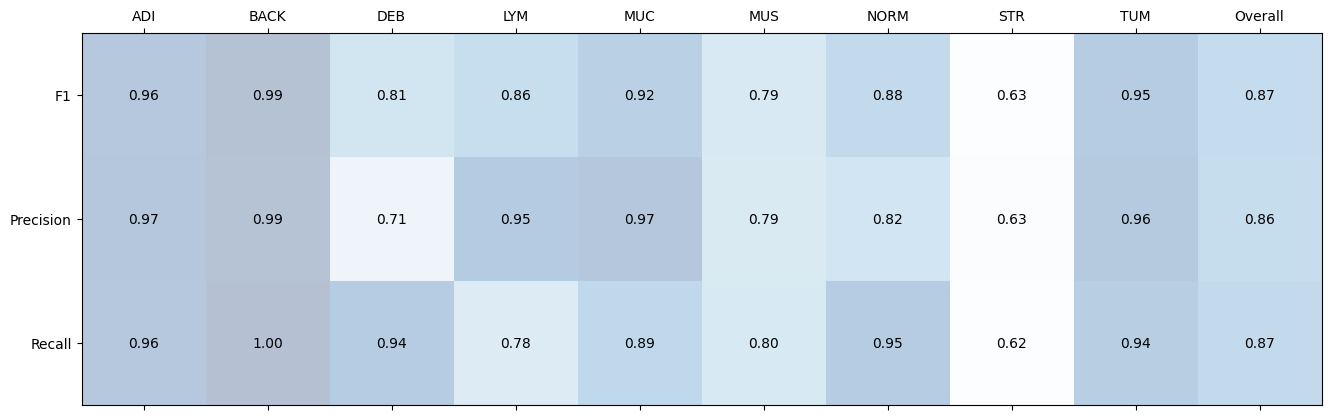

In [ ]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [ ]:
times = measure_inference_time(model, test7k_dataloader, device)

Inference Time Measurement Results:
Total Inferences: 225
Average Time: 7.50 ms
Standard Deviation: 0.41 ms
Maximum Time: 9.23 ms
Minimum Time: 7.06 ms
